In [1]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [2]:
cathodeList,timeList=ppt.getScopeWaveforms("/Users/rjn/dune/purity/UCL/vacuum/silver/30.60.120Vcm.ch4.traces",True)
anodeList,_=ppt.getScopeWaveforms("/Users/rjn/dune/purity/UCL/vacuum/silver/30.60.120Vcm.ch3.traces",True)
dt=timeList[1]-timeList[0]
fs=1./dt

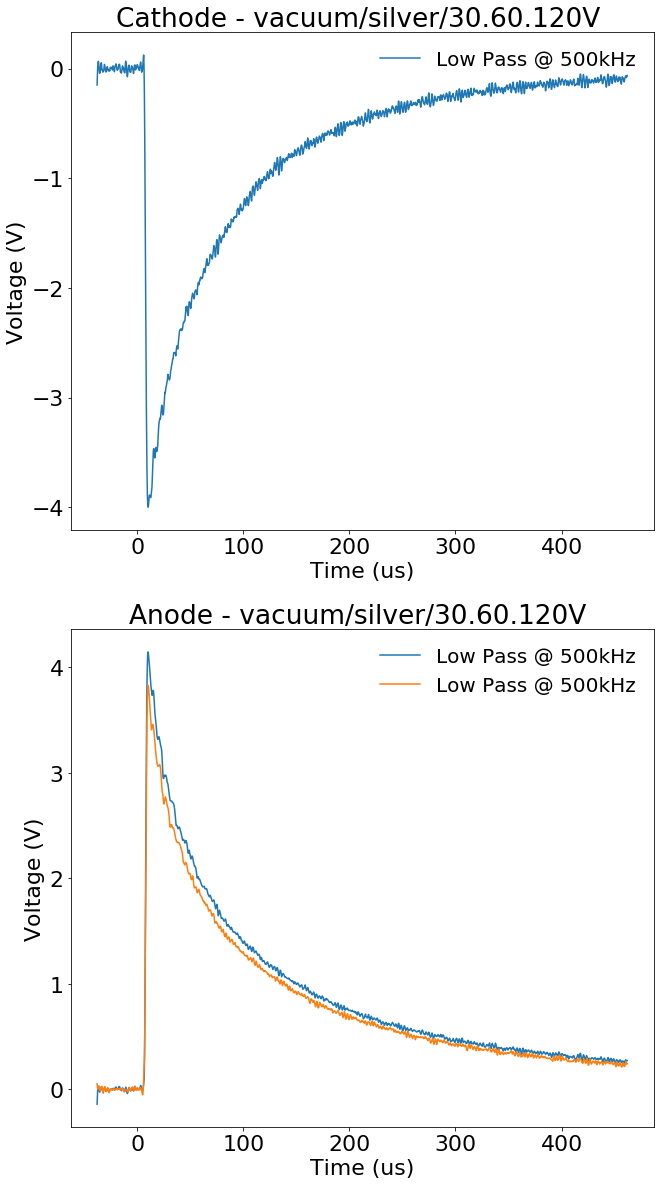

In [22]:
#smoothCat1=savgol_filter(cathodeList[0], 101, 3) # window size 101, polynomial order 3
#smoothAn1=savgol_filter(anodeList[0], 101, 3) # window size 101, polynomial order 3
lowCat=ppt.butter_lowpass_filter(cathodeList[0],0.5,fs,2)  #Since fs in MHz cut off frequency needs to match
lowAn=ppt.butter_lowpass_filter(anodeList[0],0.5,fs,2)
lowAn2=ppt.butter_lowpass_filter(anodeList[999],0.5,fs,2)


#Plot the raw and smoothed waveforms
fig, ax = plt.subplots(2,1)
#ax[0].plot(timeList,cathodeList[0],label="Raw")
#ax[0].plot(timeList,smoothCat1,label="Savitzky-Golay Smoothed")
ax[0].plot(timeList,lowCat,label="Low Pass @ 500kHz")
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Voltage (V)')
ax[0].set_title('Cathode - vacuum/silver/30.60.120V ')    
ax[0].legend(fontsize=20,loc='upper right')


#ax[1].plot(timeList,anodeList[0],label="Raw")
#ax[1].plot(timeList,smoothAn1,label="Savitzky-Golay Smoothed")
ax[1].plot(timeList,lowAn,label="Low Pass @ 500kHz")
ax[1].plot(timeList,lowAn2,label="Low Pass @ 500kHz")
ax[1].set_xlabel('Time (us)')
ax[1].set_ylabel('Voltage (V)')
ax[1].set_title('Anode - vacuum/silver/30.60.120V ')
ax[1].legend(fontsize=20,loc='upper right')
plt.subplots_adjust(bottom=0.1, right=0.8, top=2)

In [6]:
from scipy.optimize import curve_fit


def funcPreamp2(x, baseline, Q, t0,deltat1,riseTime):
    lifeTime=1e8
    tauEff=1./((1./riseTime - 1./lifeTime))
    t1=t0+deltat1
    def funcNext(x):
        #print("Here: "+str(t1))
        #secondPart= Q*tauEff*(np.exp((t1-x)/riseTime)*math.exp((t0-t1)/lifeTime)-np.exp((t0-x)/riseTime)))
        return np.where(x<t1,Q*tauEff*np.exp((t0-x)/lifeTime)*(1-np.exp((t0-x)/tauEff)),Q*tauEff*(np.exp((t1-x)/riseTime)*math.exp((t0-t1)/lifeTime)-np.exp((t0-x)/riseTime)))
    return np.where(x<t0,baseline,baseline+funcNext(x))

def funcJustExp(x,Q,t0,fallTime):
    return Q*np.exp((t0-x)/fallTime)



[  2.42534123   5.84613839 164.10861242]
[[ 1.24066862e+06 -8.39487413e+07 -2.94103617e+01]
 [-8.39487413e+07  5.68031707e+09  1.99001738e+03]
 [-2.94103617e+01  1.99001738e+03  1.03906417e-02]]


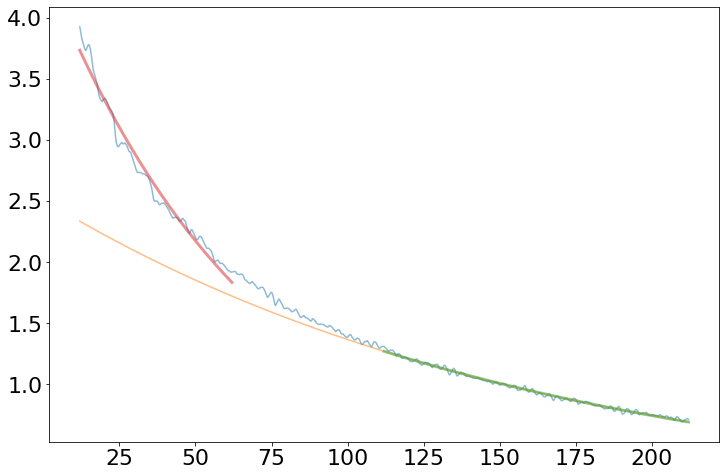

In [20]:
popt, pcov = curve_fit(funcJustExp, timeList[30000:50000],lowAn[30000:50000],bounds=([0,0,0], [1000,1000,1000]))
popt2, pcov2 = curve_fit(funcJustExp, timeList[10000:20000],lowAn[10000:20000],bounds=([0,0,0], [1000,1000,1000]))
print(popt)
print(pcov)
fig, ax = plt.subplots()
funcList=funcJustExp(timeList,*popt)
funcList2=funcJustExp(timeList,*popt2)
ax.plot(timeList[10000:50000],lowAn[10000:50000],label="Low pass",alpha=0.5)
ax.plot(timeList[10000:50000],funcList[10000:50000],label="Func",alpha=0.5)
ax.plot(timeList[30000:50000],funcList[30000:50000],label="Func",alpha=0.5,linewidth=3)
ax.plot(timeList[10000:20000],funcList2[10000:20000],label="Func",alpha=0.5,linewidth=3)

(0.8, 1.0)

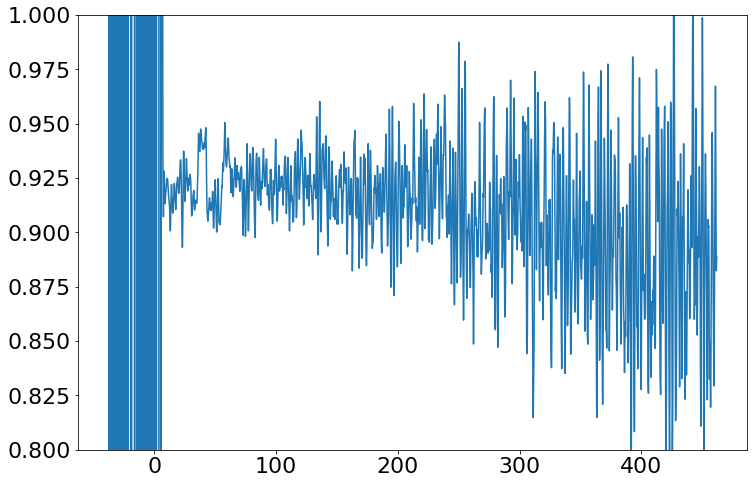

In [38]:
fig, ax = plt.subplots()
ax.plot(timeList,(lowAn2/lowAn),label="Last/First")
ax.set_ylim([0.8,1.0])